In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras import optimizers
from keras.callbacks import tensorboard_v2
from keras import backend as K
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
import datetime
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
labels = pd.read_csv('labels.csv')

In [3]:
# For running on GPU, comment out on macbook
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

True

In [4]:
labels.head()

,ID,Grookey,Scorbunny,Sobble
0,1.jpg,1,0,0
1,2.jpg,1,0,0
2,3.jpg,0,0,1
3,4.jpg,0,1,0
4,5.jpg,0,1,0


In [5]:
labels.columns

Index(['ID', 'Grookey', 'Scorbunny', 'Sobble'], dtype='object')

In [6]:
images = []
for i in range(labels.shape[0]):
    img = image.load_img('poke_dataset/images/'+ labels['ID'][i],target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    images.append(img)

In [7]:
X = np.array(images)
print(X.shape)

(88, 400, 400, 3)


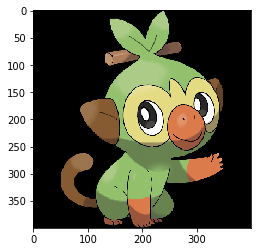

In [8]:
# show image

plt.imshow(X[0])


In [9]:
y = np.array(labels.drop(['ID'],axis=1))
print(y.shape)

(88, 3)


In [10]:
# Calculate recall (using keras backend and metrics guide as reference and wikipedia)
# recall is total union / true positives
def recall_metric(y_true, y_pred):
    # Trim total and trues into ranges between 0 and 1
    top = K.sum(K.clip(y_true * y_pred, 0, 1))
    bottom = K.sum(K.clip(y_true, 0, 1))
    return top / bottom


# precision is total union / predicted positives
def precision_metric(y_true, y_pred):
    # Trim total and predictions into ranges between 0 and 1
    top = K.sum(K.clip(y_true * y_pred, 0, 1))
    bottom = K.sum(K.clip(y_pred, 0, 1))
    return top / bottom


# f1 is 2 * precision * recall / precision + recall
def f1_metric(y_true, y_pred):
    re = recall_metric(y_true, y_pred)
    pr = precision_metric(y_true, y_pred)
    return 2 * ((re * pr) / (re + pr))

In [11]:
# OPEN CV Image Augmentation

newX = []
newY = []

# Iterate through each image
for i in range(len(X)):
    newX.append(X[i])
    newY.append(y[i])
    
    # Find center of image for rotate
    im_shape = X[0].shape[1::-1]
    center = tuple(np.array(im_shape) / 2)
    
    # Apply 6 random rotations per image
    for r in range(6):
        # Rotate
        rot_matrix = cv2.getRotationMatrix2D(center, random.randint(-90, 90), 1.0)
        rot_image = cv2.warpAffine(X[i], rot_matrix, im_shape)
                
        # Normalize
        cv2.normalize(rot_image, rot_image, 0, 255, cv2.NORM_MINMAX)
        rot_image = rot_image.astype(np.uint8)

        # Add image and label
        newX.append(rot_image)
        newY.append(y[i])
        
    # Add random noise 20 different times
    for z in range(20):
        # Get image dimensions
        row, col, channels = X[i].shape

        # Gaussian Parameters
        mean = 0
        variance = 0.0001
        sigma = variance ** 0.5

        # Setup blur
        gaussian_amt = np.random.normal(mean, sigma, (row, col, channels))
        mod_image = X[i] + gaussian_amt

        # Normalize
        cv2.normalize(mod_image, mod_image, 0, 255, cv2.NORM_MINMAX)
        mod_image = mod_image.astype(np.uint8)

        # Add image and label
        newX.append(mod_image)
        newY.append(y[i])

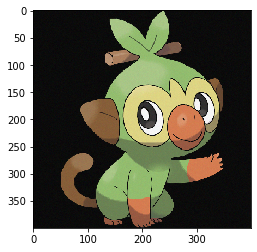

In [12]:
plt.imshow(newX[8])

In [13]:
newX[77]

array([[[ 8,  9, 11],
        [14,  9, 10],
        [11,  7,  9],
        ...,
        [14,  9, 11],
        [10, 13, 11],
        [13, 12, 12]],

       [[11, 12, 13],
        [ 9, 12,  8],
        [10,  8,  8],
        ...,
        [12,  8, 10],
        [13,  5, 11],
        [11,  9, 14]],

       [[15, 12, 12],
        [ 9, 10,  8],
        [10, 10, 12],
        ...,
        [13, 11, 10],
        [11, 10, 13],
        [ 3,  8, 13]],

       ...,

       [[11, 13, 11],
        [12, 16, 11],
        [12, 12,  9],
        ...,
        [12, 11,  8],
        [15, 10, 10],
        [11, 13,  9]],

       [[13, 12, 10],
        [11, 10,  9],
        [ 5, 11, 12],
        ...,
        [10, 18, 13],
        [ 9, 14, 17],
        [11, 10, 12]],

       [[ 9, 15,  6],
        [16, 11, 12],
        [ 9, 10, 11],
        ...,
        [10, 11,  8],
        [10, 14,  9],
        [12, 13,  9]]], dtype=uint8)

In [14]:
newY[77]

array([0, 0, 1], dtype=int64)

In [15]:
# Convert new Arrays to numpy
newX = np.asarray(newX, dtype=np.uint8)
newY = np.asarray(newY, dtype=np.uint8)

In [16]:
newX.shape

(2376, 400, 400, 3)

In [17]:
newY.shape

(2376, 3)

In [18]:
newX[77]

array([[[ 8,  9, 11],
        [14,  9, 10],
        [11,  7,  9],
        ...,
        [14,  9, 11],
        [10, 13, 11],
        [13, 12, 12]],

       [[11, 12, 13],
        [ 9, 12,  8],
        [10,  8,  8],
        ...,
        [12,  8, 10],
        [13,  5, 11],
        [11,  9, 14]],

       [[15, 12, 12],
        [ 9, 10,  8],
        [10, 10, 12],
        ...,
        [13, 11, 10],
        [11, 10, 13],
        [ 3,  8, 13]],

       ...,

       [[11, 13, 11],
        [12, 16, 11],
        [12, 12,  9],
        ...,
        [12, 11,  8],
        [15, 10, 10],
        [11, 13,  9]],

       [[13, 12, 10],
        [11, 10,  9],
        [ 5, 11, 12],
        ...,
        [10, 18, 13],
        [ 9, 14, 17],
        [11, 10, 12]],

       [[ 9, 15,  6],
        [16, 11, 12],
        [ 9, 10, 11],
        ...,
        [10, 11,  8],
        [10, 14,  9],
        [12, 13,  9]]], dtype=uint8)

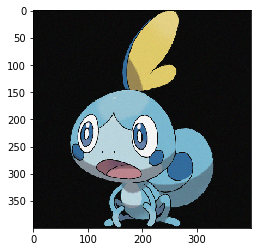

In [19]:
plt.imshow(newX[77])

In [20]:
# split the data into training and testing
# Add Shuffle here maybe, since there's gonna be
X_train, X_test, y_train, y_test = train_test_split(newX, newY, random_state=42, shuffle=True, test_size=0.1)

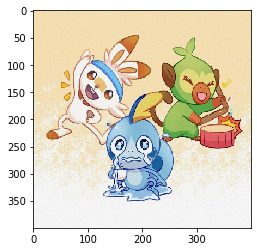

In [21]:
# Keras Image Augmentation
#datagen = image.ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True)

#datagen.fit(X_train)

plt.imshow(X_train[0])

In [22]:
y_train[0]

array([1, 1, 1], dtype=uint8)

In [36]:
# setup adam optimizer
ad = optimizers.Adam(learning_rate=0.000001)

# build the model operation

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(400,400,3)))

model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(72, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 132, 132, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 130, 130, 32)      9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      4624      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 126, 126, 64)      9280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 64)       

In [38]:
model.compile(optimizer=ad, loss='categorical_crossentropy', metrics=['accuracy', recall_metric, precision_metric, f1_metric])

In [40]:
log_dir="logs\\fit\\7\\"
tensorboard_callback = tensorboard_v2.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
results = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=4, callbacks=[tensorboard_callback])
# Issue with running out of memory (Even though I have 16GB?) will try and debug later
#model.fit(x_final, y_final, epochs=10, batch_size=64)

# Test with keras image augmentation
#model.fit_generator(datagen.flow(X_train, y_train), validation_data=(X_test, y_test), epochs=100)

Train on 2138 samples, validate on 238 samples
Epoch 1/50
2138/2138 [==============================] - 31s 14ms/step - loss: 6.4789 - accuracy: 0.4055 - recall_metric: 0.4104 - precision_metric: 0.6004 - f1_metric: 0.4775 - val_loss: 1.8870 - val_accuracy: 0.6723 - val_recall_metric: 0.5655 - val_precision_metric: 0.7691 - val_f1_metric: 0.6422
Epoch 2/50
2138/2138 [==============================] - 30s 14ms/step - loss: 8.8673 - accuracy: 0.4836 - recall_metric: 0.4683 - precision_metric: 0.6806 - f1_metric: 0.5437 - val_loss: 2.0075 - val_accuracy: 0.7731 - val_recall_metric: 0.6413 - val_precision_metric: 0.8648 - val_f1_metric: 0.7257
Epoch 3/50
2138/2138 [==============================] - 30s 14ms/step - loss: 12.5313 - accuracy: 0.5056 - recall_metric: 0.4917 - precision_metric: 0.7077 - f1_metric: 0.5686 - val_loss: 18.6966 - val_accuracy: 0.5882 - val_recall_metric: 0.5681 - val_precision_metric: 0.7716 - val_f1_metric: 0.6450
Epoch 4/50
2138/2138 [=============================

Epoch 28/50
2138/2138 [==============================] - 30s 14ms/step - loss: 1359.7983 - accuracy: 0.5819 - recall_metric: 0.5676 - precision_metric: 0.8011 - f1_metric: 0.6510 - val_loss: 1135.5052 - val_accuracy: 0.5966 - val_recall_metric: 0.5901 - val_precision_metric: 0.8086 - val_f1_metric: 0.6723
Epoch 29/50
2138/2138 [==============================] - 30s 14ms/step - loss: 1432.8459 - accuracy: 0.6076 - recall_metric: 0.5772 - precision_metric: 0.8184 - f1_metric: 0.6641 - val_loss: 607.0365 - val_accuracy: 0.7101 - val_recall_metric: 0.6619 - val_precision_metric: 0.8929 - val_f1_metric: 0.7494
Epoch 30/50
2138/2138 [==============================] - 31s 14ms/step - loss: 1559.1033 - accuracy: 0.6099 - recall_metric: 0.5798 - precision_metric: 0.8218 - f1_metric: 0.6669 - val_loss: 1225.1732 - val_accuracy: 0.6975 - val_recall_metric: 0.5800 - val_precision_metric: 0.7895 - val_f1_metric: 0.6593
Epoch 31/50
2138/2138 [==============================] - 30s 14ms/step - loss: 1

In [53]:
img = image.load_img('test2.jpg',target_size=(400,400,3))
img = image.img_to_array(img)
img = img/255

Sobble (0.917)
Grookey (0.0827)
Scorbunny (8.34e-20)


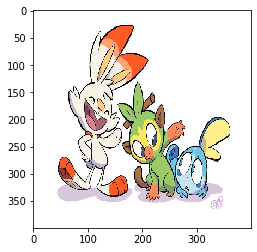

In [54]:
# top 3 predictions

classes = np.array(labels.columns[1:])
proba = model.predict(img.reshape(1,400,400,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

In [29]:
%tensorboard --logdir logs/fit

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 20052.